# Machine Translation and the Dataset



In [1]:
import os
import torch
from d2l import torch as d2l

Downloading and Preprocessing the Dataset

In [2]:
class MTFraEng(d2l.DataModule):  
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()
raw_text[:60]

'Go.\tVa !\nHi.\tSalut !\nRun!\tCours\u202f!\nRun!\tCourez\u202f!\nWho?\tQui ?\nW'

Proceed with several preprocessing steps

In [3]:
@d2l.add_to_class(MTFraEng)  
def _preprocess(self, text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

text = data._preprocess(raw_text)
text[:60]

'go .\tva !\nhi .\tsalut !\nrun !\tcours !\nrun !\tcourez !\nwho ?\tqu'

Tokenization

In [4]:
@d2l.add_to_class(MTFraEng)  
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'<bos> {parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:4], tgt[:4]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>']],
 [['<bos>', 'va', '!', '<eos>'],
  ['<bos>', 'salut', '!', '<eos>'],
  ['<bos>', 'cours', '!', '<eos>'],
  ['<bos>', 'courez', '!', '<eos>']])

Plot the histogram of the number of tokens per text sequence

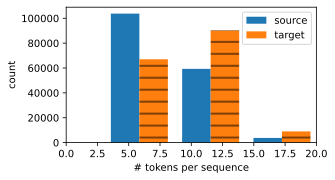

In [5]:
d2l.set_figsize((4.5, 2.5))
_, _, patches = d2l.plt.hist([[len(l) for l in src],
                              [len(l) for l in tgt]])
d2l.plt.xlabel('
d2l.plt.xlim([0, 20])
for patch in patches[1].patches: patch.set_hatch('-')
_ = d2l.plt.legend(['source', 'target'])

Each sequence example
has a fixed length.
Transform
text sequences into minibatches for training.
Vocabulary
Putting All Things Together

In [7]:
@d2l.add_to_class(MTFraEng)  
def __init__(self, batch_size, num_steps, num_train=1000, num_val=1000):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())

@d2l.add_to_class(MTFraEng)  
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_one(sentences, vocab):
        pad_or_trim = lambda s, n: (
            s[:n] if len(s) > n else s + ['<pad>'] * (n - len(s)))
        sentences = [pad_or_trim(seq, self.num_steps) for seq in sentences]
        if vocab is None: vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[sent] for sent in sentences])
        return array, vocab
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab = _build_one(src, src_vocab)
    tgt_array, tgt_vocab = _build_one(tgt, tgt_vocab)
    return (src_array, tgt_array[:,:-1], tgt_array[:,1:]), src_vocab, tgt_vocab

@d2l.add_to_class(MTFraEng)  
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

Read the first minibatch from the English-French dataset

In [8]:
data = MTFraEng(batch_size=3, num_steps=6)
src, tgt, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('target:', tgt.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[445, 244,   2,   4,   5,   5],
        [220, 198,  36,   2,   4,   5],
        [ 54, 423, 147,   7,   4,   5]], dtype=torch.int32)
target: tensor([[  4,   7,   0,   5,   6],
        [  4,  17,   7,   2,   5],
        [  4, 380, 563,  19,   8]], dtype=torch.int32)
label: tensor([[  7,   0,   5,   6,   6],
        [ 17,   7,   2,   5,   6],
        [380, 563,  19,   8,   5]], dtype=torch.int32)


In [10]:
@d2l.add_to_class(MTFraEng)  
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src+'\t'+tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>']
